# Skin Cancer Image Processing with Pre-Trained Models

In this notebook, pre-trained models will be used to classify skin lesion images. Then, the modeling results will be compared with the final model found by iterationg varies CNN models in the [Image Processing and Modeling](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Image_Processing_and_Modeling.ipynb) notebook.

In [3]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

# importing pre-trained networks
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

In [4]:
# Define modeling results display function:
def visualize_modeling_results(results):
    '''   
    Input: model history results
    '''
    history = results.history
    
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower left')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## 1. Data Preperation

In [5]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET_512x512.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12431,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12432,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12433,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12434,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg


In [6]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [7]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       4845
malignant    4108
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
2034,ISIC_0714807,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,20.0,upper extremity,benign
6216,ISIC_1984995,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,30.0,palms/soles,benign
1848,ISIC_0663588,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,torso,benign
11624,ISIC_0071693,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,40.0,head/neck,malignant
4775,ISIC_1558731,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,torso,benign
...,...,...,...,...,...,...
2578,ISIC_0884397,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,torso,benign
11825,ISIC_0072990,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,anterior torso,malignant
672,ISIC_0307958,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,palms/soles,benign
6213,ISIC_1984152,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign


In [10]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Test dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Test dataset: 
 benign       1211
malignant    1028
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
8227,ISIC_0028219,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,45.0,upper extremity,malignant
3879,ISIC_1289942,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,torso,benign
2819,ISIC_0954236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
11196,ISIC_0068438,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,75.0,palms/soles,malignant
1808,ISIC_0652205,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,lower extremity,benign
...,...,...,...,...,...,...
10278,ISIC_0062029,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,80.0,anterior torso,malignant
5484,ISIC_1768051,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,70.0,lower extremity,benign
4342,ISIC_1431236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign
3993,ISIC_1326366,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,lower extremity,benign


In [11]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       694
malignant    550
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10405,ISIC_0062914,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,lower extremity,malignant
6392,ISIC_2038024,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
1483,ISIC_0552960,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,lower extremity,benign
4190,ISIC_1384527,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,lower extremity,benign
8635,ISIC_0032724,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,posterior torso,malignant
...,...,...,...,...,...,...
8450,ISIC_0030929,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,55.0,upper extremity,malignant
4949,ISIC_1611285,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,30.0,lower extremity,benign
2239,ISIC_0772957,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
10402,ISIC_0062891,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,35.0,anterior torso,malignant


## 2. Image Preprocessing

In [12]:
# Instantiating a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Creating the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_train),
                                                seed=42,
                                                class_mode='binary')


# Creating the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 64x64
                                              target_size=(64, 64),
                                              batch_size=len(df_val),
                                              seed=42,
                                              class_mode='binary')


# Setting aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_test),
                                                seed=42,
                                                class_mode='binary')

Found 8953 validated image filenames belonging to 2 classes.
Found 2239 validated image filenames belonging to 2 classes.
Found 1244 validated image filenames belonging to 2 classes.


In [13]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [14]:
# Create image and labels data sets by using next() fnc, it returns next item in the generator above:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [15]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


In [16]:
# Explore dataset again
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of test samples: " + str(m_test))

print ("train_images shape: " + str(train_images.shape))   
print ("train_labels shape: " + str(train_labels.shape))

print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 8953
Number of validation samples: 2239
Number of test samples: 1244
train_images shape: (8953, 64, 64, 3)
train_labels shape: (8953,)
val_images shape: (2239, 64, 64, 3)
val_labels shape: (2239,)
test_images shape: (1244, 64, 64, 3)
test_labels shape: (1244,)


In [17]:
# Reshaping image sets:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(8953, 12288)
(2239, 12288)
(1244, 12288)


## 3. Modeling with Pre-Trained Models

## 3.1. VGG-16 Model

### First iteration 

In [19]:
# Defined pretrained VGG-16 model:
vgg16_model = VGG16(weights='imagenet',
               include_top=False,
               input_shape=(64, 64, 3))

In [20]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [23]:
# Define early stop criteria for model:
early_stop = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='../Saved_Models/vgg16_best_model.h5', monitor='val_recall', mode='max', 
                             save_best_only=True, verbose=1)]


In [26]:
# Create architecture of the model:
vgg16_withfinal = models.Sequential()
vgg16_withfinal.add(vgg16_model)

# adding dense layers from CNN iterations final model:
vgg16_withfinal.add(layers.Flatten())

vgg16_withfinal.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(l2=0.001)))
vgg16_withfinal.add(layers.Dense(1, activation='sigmoid'))

In [27]:
vgg16_withfinal.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 14,977,089
Trainable params: 14,977,089
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Make sure that the pretrianed layer is untrainable
# We don't want to change the weights durinf optimization
vgg16_model.trainable = False

In [31]:
# Print out the layers' trainability condition:
for layer in vgg16_withfinal.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_2 True
dense_3 True


In [32]:
# Compile and fit the model:
vgg16_withfinal.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

vgg16_withfinal_history = vgg16_withfinal.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    callbacks = early_stop,
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.7958 - recall: 0.7033 - precision: 0.8259 - auc: 0.8676
Epoch 00001: val_recall improved from -inf to 0.65175, saving model to ../Saved_Models\vgg16_best_model.h5
280/280 [==============================] - 188s 671ms/step - loss: 0.6920 - accuracy: 0.7958 - recall: 0.7033 - precision: 0.8259 - auc: 0.8676 - val_loss: 0.6703 - val_accuracy: 0.8057 - val_recall: 0.6518 - val_precision: 0.8969 - val_auc: 0.8865
Epoch 2/30
280/280 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.8204 - recall: 0.7493 - precision: 0.8419 - auc: 0.8956
Epoch 00002: val_recall improved from 0.65175 to 0.89202, saving model to ../Saved_Models\vgg16_best_model.h5
280/280 [==============================] - 226s 807ms/step - loss: 0.6383 - accuracy: 0.8204 - recall: 0.7493 - precision: 0.8419 - auc: 0.8956 - val_loss: 0.7048 - val_accuracy: 0.7847 - val_recall: 0.8920 - val_precision: 0.7120 - val_auc

Epoch 19/30
280/280 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.8606 - recall: 0.8216 - precision: 0.8676 - auc: 0.9391
Epoch 00019: val_recall did not improve from 0.91440
280/280 [==============================] - 243s 868ms/step - loss: 0.5114 - accuracy: 0.8606 - recall: 0.8216 - precision: 0.8676 - auc: 0.9391 - val_loss: 0.5351 - val_accuracy: 0.8535 - val_recall: 0.8920 - val_precision: 0.8086 - val_auc: 0.9401
Epoch 20/30
280/280 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.8632 - recall: 0.8267 - precision: 0.8688 - auc: 0.9411
Epoch 00020: val_recall did not improve from 0.91440
280/280 [==============================] - 228s 815ms/step - loss: 0.5041 - accuracy: 0.8632 - recall: 0.8267 - precision: 0.8688 - auc: 0.9411 - val_loss: 0.5219 - val_accuracy: 0.8611 - val_recall: 0.7714 - val_precision: 0.9125 - val_auc: 0.9395
Epoch 21/30
280/280 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.8614 - r

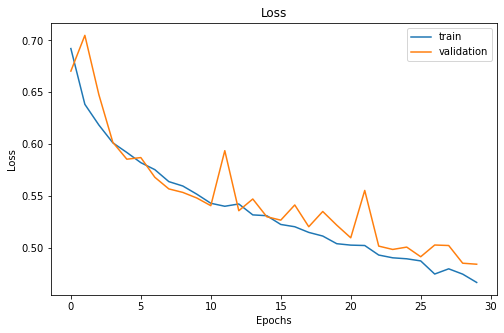

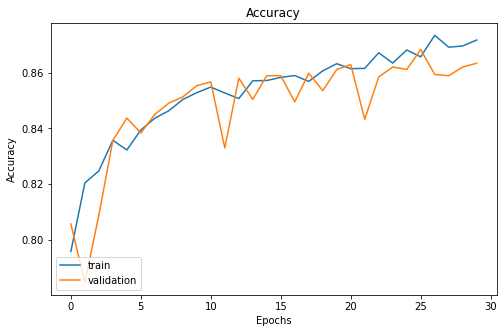

In [33]:
# Visualize the modeling results:
visualize_modeling_results(vgg16_withfinal_history)

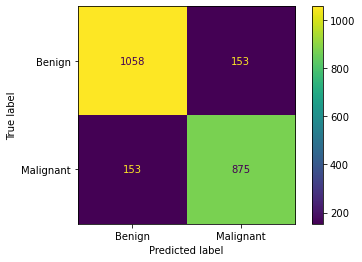

In [35]:
# Plot confusion matrix:
vgg16_withfinal_predictions = (vgg16_withfinal.predict(val_images) > 0.5).astype("int32")
vgg16_withfinal_cm = confusion_matrix(val_labels, vgg16_withfinal_predictions)
vgg16_withfinal_disp = ConfusionMatrixDisplay(confusion_matrix=vgg16_withfinal_cm, display_labels=['Benign', 'Malignant'])
vgg16_withfinal_disp.plot()
plt.show()

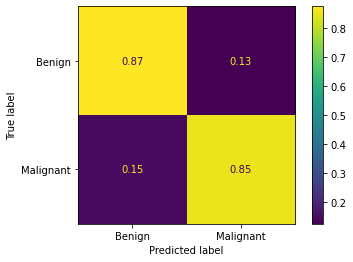

In [36]:
# Plot confusion matrix with percentages:
vgg16_withfinal_predictions = (vgg16_withfinal.predict(val_images) > 0.5).astype("int32")
vgg16_withfinal_cm = confusion_matrix(val_labels, vgg16_withfinal_predictions, normalize='true')
vgg16_withfinal_disp = ConfusionMatrixDisplay(confusion_matrix=vgg16_withfinal_cm, display_labels=['Benign', 'Malignant'])
vgg16_withfinal_disp.plot()
plt.show()

In [34]:
# Evaluate train and validation set:
vgg16_withfinal_results_train = vgg16_withfinal.evaluate(train_images, train_labels)
vgg16_withfinal_results_validation = vgg16_withfinal.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
vgg16_withfinal_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    vgg16_withfinal_results[vgg16_withfinal_results.columns[i]]['Train'] = vgg16_withfinal_results_train[i]
    vgg16_withfinal_results[vgg16_withfinal_results.columns[i]]['Validation'] = vgg16_withfinal_results_validation[i]
    
vgg16_withfinal_results

70/70 [==============================] - 78s 1s/step - loss: 0.4843 - accuracy: 0.8633 - recall: 0.8512 - precision: 0.8512 - auc: 0.9417


,Loss,Accuracy,Recall,Precision,AUC
Train,0.451199,0.879929,0.858325,0.877333,0.954424
Validation,0.484292,0.863332,0.851167,0.851167,0.941661


In [37]:
# Save the model results
vgg16_withfinal_results.to_csv('../Saved_Models/vgg16_withfinal_results.csv', index=False)

In [38]:
# Save weights of the model
vgg16_withfinal.save_weights('../Saved_Models/vgg16_withfinal_weights.h5')

**Analysis:**

### Second Iteration

In [60]:
# Create architecture of the model:
vgg16_withfinal2 = models.Sequential()
vgg16_withfinal2.add(vgg16_model)

# adding more dense layers of CNN iterations from final model:
vgg16_withfinal2.add(layers.Flatten())
vgg16_withfinal2.add(Flatten())
vgg16_withfinal2.add(Dense(512, activation='relu', kernel_regularizer=l2(l2=0.001)))
vgg16_withfinal2.add(Dropout(0.5))
vgg16_withfinal2.add(Dense(256, kernel_regularizer=l2(l2=0.001)))
vgg16_withfinal2.add(BatchNormalization())
vgg16_withfinal2.add(Activation('relu'))
vgg16_withfinal2.add(Dropout(0.5))
vgg16_withfinal2.add(Dense(16, kernel_regularizer=l2(l2=0.001)))
vgg16_withfinal2.add(BatchNormalization())
vgg16_withfinal2.add(Activation('relu'))
vgg16_withfinal2.add(Dropout(0.5))
vgg16_withfinal2.add(Dense(4, kernel_regularizer=l2(l2=0.001)))
vgg16_withfinal2.add(BatchNormalization())
vgg16_withfinal2.add(Activation('relu'))

vgg16_withfinal2.add(layers.Dense(1, activation='sigmoid'))

In [40]:
vgg16_withfinal2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)              

In [42]:
# Make sure that the pretrianed layers are untrainable
for layer in vgg16_model.layers:
    layer.trainable=False

In [43]:
# Print out the layers' trainability condition:
for layer in vgg16_withfinal2.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_2 True
flatten_3 True
dense_4 True
dropout True
dense_5 True
batch_normalization True
activation True
dropout_1 True
dense_6 True
batch_normalization_1 True
activation_1 True
dropout_2 True
dense_7 True
batch_normalization_2 True
activation_2 True
dense_8 True


In [46]:
# Define early stop criteria for model:
early_stop2 = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='../Saved_Models/vgg16model2_best_model.h5', monitor='val_recall', mode='max', 
                             save_best_only=True, verbose=1)]


In [47]:
# Compile and fit the model:
vgg16_withfinal2.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

vgg16_withfinal2_history = vgg16_withfinal2.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    callbacks = early_stop2,
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.6149 - recall: 0.5148 - precision: 0.5924 - auc: 0.6544
Epoch 00001: val_recall improved from -inf to 0.56031, saving model to ../Saved_Models\vgg16model2_best_model.h5
280/280 [==============================] - 367s 1s/step - loss: 1.8435 - accuracy: 0.6149 - recall: 0.5148 - precision: 0.5924 - auc: 0.6544 - val_loss: 1.7578 - val_accuracy: 0.7655 - val_recall: 0.5603 - val_precision: 0.8875 - val_auc: 0.8588
Epoch 2/30
280/280 [==============================] - ETA: 0s - loss: 1.7545 - accuracy: 0.7182 - recall: 0.5757 - precision: 0.7520 - auc: 0.7835
Epoch 00002: val_recall improved from 0.56031 to 0.61770, saving model to ../Saved_Models\vgg16model2_best_model.h5
280/280 [==============================] - 401s 1s/step - loss: 1.7545 - accuracy: 0.7182 - recall: 0.5757 - precision: 0.7520 - auc: 0.7835 - val_loss: 1.6792 - val_accuracy: 0.7887 - val_recall: 0.6177 - val_precision: 0.8881 - v

Epoch 19/30
280/280 [==============================] - ETA: 0s - loss: 1.3657 - accuracy: 0.8281 - recall: 0.7700 - precision: 0.8419 - auc: 0.9039
Epoch 00019: val_recall did not improve from 0.80253
280/280 [==============================] - 402s 1s/step - loss: 1.3657 - accuracy: 0.8281 - recall: 0.7700 - precision: 0.8419 - auc: 0.9039 - val_loss: 1.3240 - val_accuracy: 0.8392 - val_recall: 0.7267 - val_precision: 0.9044 - val_auc: 0.9268


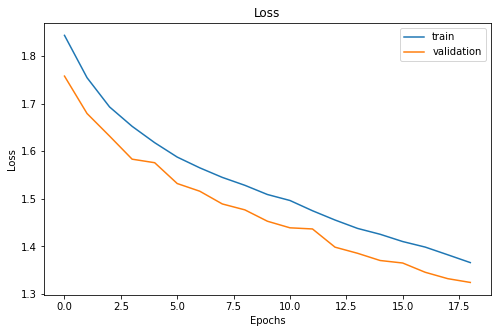

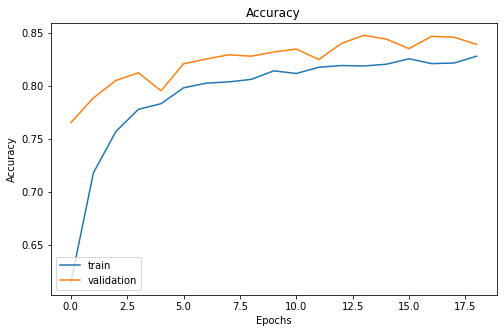

In [48]:
# Visualize the modeling results:
visualize_modeling_results(vgg16_withfinal2_history)

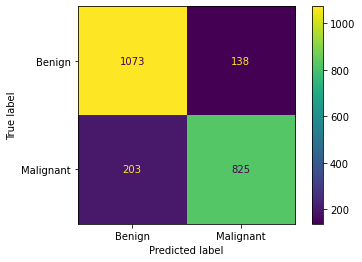

In [49]:
# Plot confusion matrix:
vgg16_withfinal2_predictions = (vgg16_withfinal2.predict(val_images) > 0.5).astype("int32")
vgg16_withfinal2_cm = confusion_matrix(val_labels, vgg16_withfinal2_predictions)
vgg16_withfinal2_disp = ConfusionMatrixDisplay(confusion_matrix=vgg16_withfinal2_cm, display_labels=['Benign', 'Malignant'])
vgg16_withfinal2_disp.plot()
plt.show()

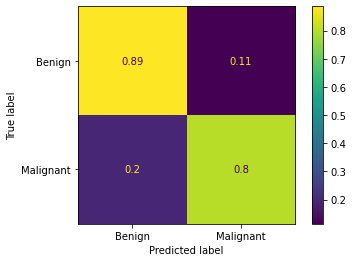

In [50]:
# Plot confusion matrix with percentages:
vgg16_withfinal2_predictions = (vgg16_withfinal2.predict(val_images) > 0.5).astype("int32")
vgg16_withfinal2_cm = confusion_matrix(val_labels, vgg16_withfinal2_predictions, normalize='true')
vgg16_withfinal2_disp = ConfusionMatrixDisplay(confusion_matrix=vgg16_withfinal2_cm, display_labels=['Benign', 'Malignant'])
vgg16_withfinal2_disp.plot()
plt.show()

In [51]:
# Evaluate train and validation set:
vgg16_withfinal2_results_train = vgg16_withfinal2.evaluate(train_images, train_labels)
vgg16_withfinal2_results_validation = vgg16_withfinal2.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
vgg16_withfinal2_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    vgg16_withfinal2_results[vgg16_withfinal2_results.columns[i]]['Train'] = vgg16_withfinal2_results_train[i]
    vgg16_withfinal2_results[vgg16_withfinal2_results.columns[i]]['Validation'] = vgg16_withfinal2_results_validation[i]
    
vgg16_withfinal2_results

70/70 [==============================] - 76s 1s/step - loss: 1.3853 - accuracy: 0.8477 - recall: 0.8025 - precision: 0.8567 - auc: 0.9240


,Loss,Accuracy,Recall,Precision,AUC
Train,1.37118,0.848431,0.800633,0.85942,0.933046
Validation,1.38529,0.8477,0.802529,0.856698,0.923997


In [52]:
# Save the model results
vgg16_withfinal2_results.to_csv('../Saved_Models/vgg16_withfinal2_results.csv', index=False)

### Test/Holdout Set Evaluation:

In [54]:
# Test/Holdout set scores for first iteration of VGG-16 model:
score1 = vgg16_withfinal.evaluate(test_images, test_labels)

39/39 [==============================] - 26s 672ms/step - loss: 0.4424 - accuracy: 0.8923 - recall: 0.8436 - precision: 0.9062 - auc: 0.9570


In [55]:
print("%s: %.2f%%" % (vgg16_withfinal.metrics_names[1], score1[1]*100))
print("%s: %.2f%%" % (vgg16_withfinal.metrics_names[2], score1[2]*100))

accuracy: 89.23%
recall: 84.36%


In [56]:
# # Test/Holdout set scores for second iteration of VGG-16 model:
score2 = vgg16_withfinal2.evaluate(test_images, test_labels)

39/39 [==============================] - 14s 355ms/step - loss: 1.3589 - accuracy: 0.8625 - recall: 0.7982 - precision: 0.8798 - auc: 0.9381


In [57]:
print("%s: %.2f%%" % (vgg16_withfinal2.metrics_names[1], score2[1]*100))
print("%s: %.2f%%" % (vgg16_withfinal2.metrics_names[2], score2[2]*100))

accuracy: 86.25%
recall: 79.82%
